# Mango Ripening Classification Task

In this notebook, a binary classification task is performed where mangos are classified as naturally ripened or artificially ripened 
based on the images. 
Contents of the notebook:
1. Data Preprocessing
2. Modelling using various supervised learning algorithms
3. Results of the experiments

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing the nescessary libraries
import os 
import cv2 
import math
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import * 
from tqdm import tqdm 
from PIL import Image

from sklearn.model_selection import train_test_split

In [3]:
# Walk through the image classification directory and find out how many files (images) are in each subdirectory.
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir("/content/gdrive/MyDrive/Mango")

There are 2 directories and 0 images in '/content/gdrive/MyDrive/Mango'.
There are 0 directories and 41 images in '/content/gdrive/MyDrive/Mango/NATURALLY RIPENED'.
There are 0 directories and 14 images in '/content/gdrive/MyDrive/Mango/ARTIFICIALLY RIPENED'.


It is an imbalanced dataset, as there are 41 images of naturall ripened mangoes and 14 images of artificically ripened mangos.

Natural mango


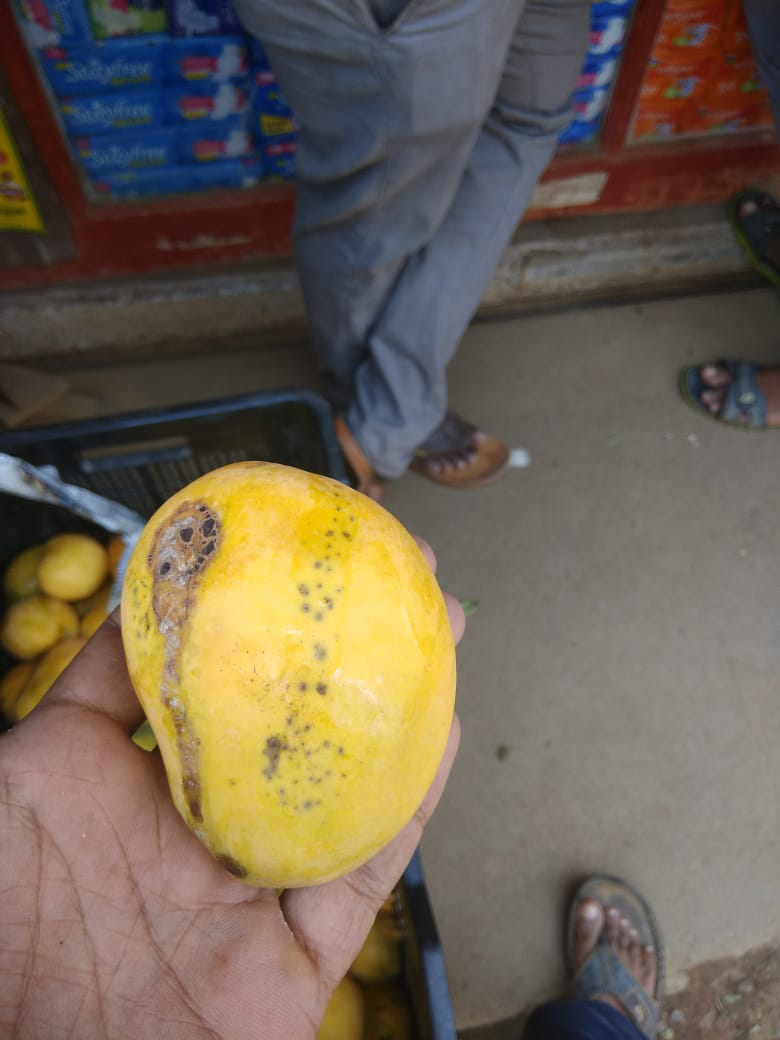

In [4]:
# Plotting some random images from each of the classes 
class_names = ["NATURALLY RIPENED", "ARTIFICIALLY RIPENED"]
dir = "/content/gdrive/MyDrive/Mango"

def plot_random(class_name):
  filename = choice(os.listdir(dir + "/" + class_name))
  filepath = dir + "/" + class_name + "/" + filename
  return filepath

filepath_natural = plot_random(class_names[0])
print("Natural mango")
Image.open(filepath_natural)

Artificial mango


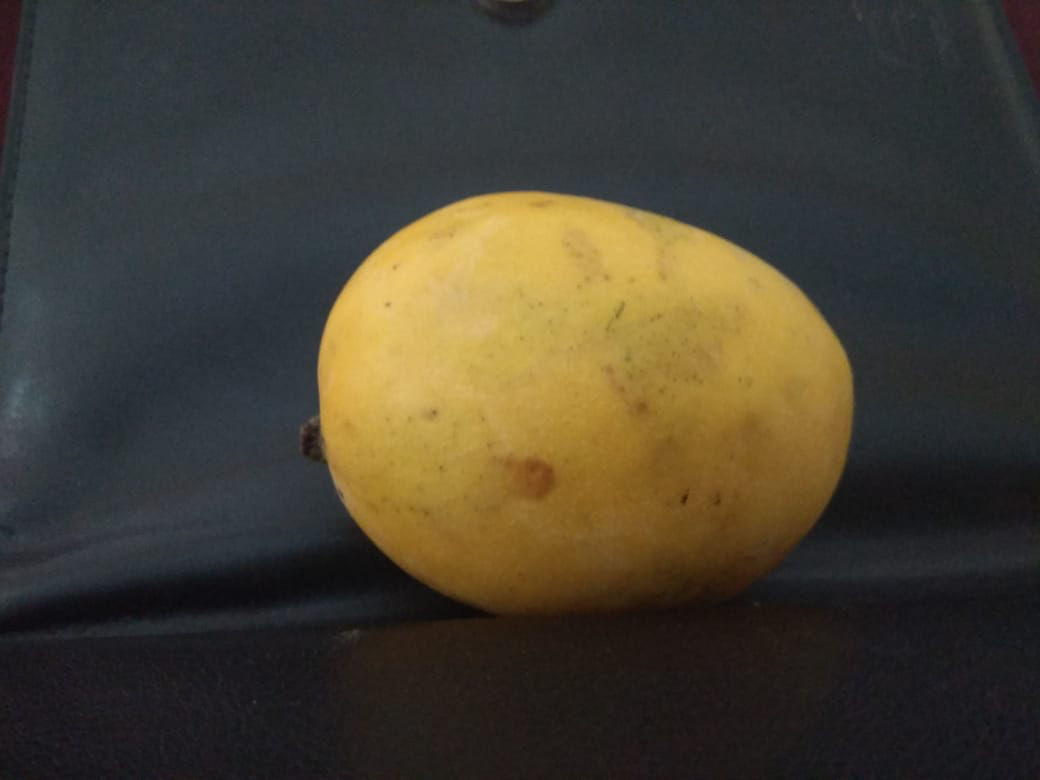

In [5]:
filepath_artificial  = plot_random(class_names[1])
print("Artificial mango")
Image.open(filepath_artificial)

## 1. Data preprocessing 

In this portion we convert all the images to grayscale images of fixed dimension (128 x 128).
Then the gray scale images are converted to numerical data where each pixel is a feature which is stored in a pandas dataframe.
The pixels were normalised.


100%|██████████| 14/14 [00:02<00:00,  4.95it/s]


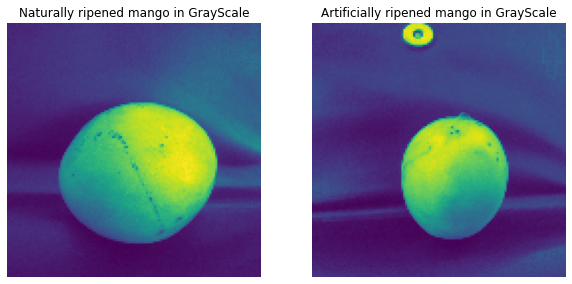

In [6]:
natural_mango = "/content/gdrive/MyDrive/Mango/NATURALLY RIPENED"
artificial_mango = "/content/gdrive/MyDrive/Mango/ARTIFICIALLY RIPENED"

natural_mango_data = []
artificial_mango_data = []
for image in tqdm(os.listdir(natural_mango)): 
    path = os.path.join(natural_mango, image)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (128, 128)).flatten()   
    np_img = np.asarray(img)
    natural_mango_data.append(img) 
    
for image2 in tqdm(os.listdir(artificial_mango)): 
    path = os.path.join(artificial_mango, image2)
    img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # grayscale
    img2 = cv2.resize(img2, (128, 128)).flatten() # resizing the image
    np_img2 = np.asarray(img2)
    artificial_mango_data.append(img2)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(np_img.reshape(128, 128))
plt.axis('off')
plt.title("Naturally ripened mango in GrayScale");
plt.subplot(1, 2, 2)
plt.imshow(np_img2.reshape(128, 128))
plt.axis('off')
plt.title("Artificially ripened mango in GrayScale");

In [7]:
# Converting the image data to a pandas dataframe
def dataframe_converter(np_array):
  feature_length = len(np_array[0])
  cols = ["pixel" + str(i+1) for i in range(feature_length)]
  df = pd.DataFrame(np_array, columns=cols)
  return df

artificial_df = dataframe_converter(np.asarray(artificial_mango_data))
artificial_df["labels"] = 1 # 1 - for artificially ripened mangos
print("Artificial Mango dataset")
print(artificial_df.head())

natural_df = dataframe_converter(np.asarray(natural_mango_data))
natural_df["labels"] = 0 # 0 - for naturally ripened mangos
print("Natural Mango dataset")
print(natural_df.head())

Artificial Mango dataset
   pixel1  pixel2  pixel3  pixel4  ...  pixel16382  pixel16383  pixel16384  labels
0      36      41      40      38  ...          22          21          25       1
1      43      41      45      44  ...          22          23          23       1
2      39      39      41      40  ...          23          22          22       1
3      37      36      38      33  ...          30          30          26       1
4      35      35      37      36  ...          23          26          25       1

[5 rows x 16385 columns]
Natural Mango dataset
   pixel1  pixel2  pixel3  pixel4  ...  pixel16382  pixel16383  pixel16384  labels
0      22      17      19      25  ...          75          97          84       0
1      29      31      32      30  ...          18          18          18       0
2      21      26      20      23  ...          19          16          17       0
3      26      29      31      28  ...          20          23          21       0
4      52     

**Note:**
Initially a naturally ripened mango dataframe was constructed followed by artificially ripened mango dataframe was constructed. The two dataframes were then concatenated and shuffled so that while constructing the model, the model doesn't learn and predict according to the order of the data. 

In [8]:
# Concatenating the dataframes and shuffling them in-place
dataframes = [natural_df, artificial_df]
df = pd.concat(dataframes)
df = df.sample(frac=1).reset_index(drop=True)
df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel16346,pixel16347,pixel16348,pixel16349,pixel16350,pixel16351,pixel16352,pixel16353,pixel16354,pixel16355,pixel16356,pixel16357,pixel16358,pixel16359,pixel16360,pixel16361,pixel16362,pixel16363,pixel16364,pixel16365,pixel16366,pixel16367,pixel16368,pixel16369,pixel16370,pixel16371,pixel16372,pixel16373,pixel16374,pixel16375,pixel16376,pixel16377,pixel16378,pixel16379,pixel16380,pixel16381,pixel16382,pixel16383,pixel16384,labels
0,35,37,37,38,39,41,38,37,39,38,43,39,40,41,39,40,39,41,42,44,42,40,40,41,43,43,42,42,40,38,40,41,41,41,38,41,40,40,41,39,...,37,38,38,38,36,34,36,39,35,37,37,39,39,39,38,34,37,37,37,36,33,35,37,35,35,39,35,36,36,33,36,34,33,36,30,32,33,33,30,1
1,21,26,20,23,25,24,25,25,24,24,27,25,26,27,27,26,28,26,27,26,28,28,26,26,28,31,30,29,30,31,33,34,33,29,29,34,34,32,33,33,...,28,26,26,28,28,31,30,29,29,28,29,28,35,34,32,33,30,35,27,28,31,29,28,30,26,28,26,26,29,23,24,23,22,18,21,15,19,16,17,0
2,30,29,30,34,29,35,35,33,35,35,36,36,38,37,37,39,37,37,41,37,38,40,40,37,42,39,40,40,41,41,42,42,41,41,46,42,46,47,43,46,...,20,22,20,21,21,21,21,24,19,21,21,23,22,21,21,19,25,22,20,19,20,20,17,19,20,23,17,16,21,19,17,15,17,18,19,19,19,20,15,0
3,39,40,39,41,40,41,41,41,42,42,41,41,38,41,44,42,45,45,41,41,44,44,46,46,46,45,42,45,48,46,46,45,43,46,46,44,46,45,44,46,...,38,40,39,40,39,40,38,40,40,40,40,41,41,40,39,38,41,38,41,40,37,38,40,38,40,39,39,36,37,37,35,39,37,35,37,35,38,39,35,1
4,29,30,30,33,35,34,37,34,37,34,34,36,39,37,38,37,36,38,37,36,38,41,39,41,38,39,39,34,39,38,40,39,36,43,41,40,41,44,44,43,...,25,22,24,26,23,25,28,30,28,28,28,29,28,28,28,31,27,28,28,31,31,28,32,30,31,31,29,32,31,32,34,34,32,33,31,28,31,32,27,0
5,117,100,96,117,85,89,71,75,66,61,80,72,67,67,60,30,35,34,30,30,32,35,36,37,41,43,40,44,43,40,43,45,47,50,53,54,58,49,48,53,...,176,197,201,213,194,205,223,209,202,198,30,34,43,53,56,45,65,94,91,87,78,53,43,63,84,92,82,64,50,65,73,73,62,66,60,82,74,62,75,0
6,34,39,33,37,35,36,36,38,39,39,38,37,38,41,41,40,41,40,44,42,40,41,44,44,41,42,46,42,44,44,45,44,47,52,50,50,49,54,54,53,...,33,31,33,31,31,30,33,32,31,27,28,32,31,32,31,29,29,29,31,30,29,29,29,28,26,30,27,29,26,28,25,30,28,26,27,27,28,28,25,0
7,36,41,40,38,39,41,38,39,40,42,39,43,44,44,43,44,42,46,42,42,45,44,45,47,47,46,48,48,45,46,47,45,47,44,43,46,46,44,45,43,...,18,14,21,19,18,16,20,18,16,16,17,20,20,18,20,22,17,17,21,19,20,20,21,19,17,18,17,21,21,18,21,17,21,20,21,21,22,21,25,1
8,22,31,42,51,57,48,50,48,52,59,59,48,53,46,37,73,71,79,50,46,39,28,31,44,36,18,16,25,33,59,67,62,25,17,18,20,26,35,46,52,...,21,21,22,23,24,26,32,40,40,40,36,35,44,41,46,54,55,100,95,91,134,110,89,81,86,80,93,92,95,97,105,94,82,77,112,119,117,118,114,0
9,34,32,32,36,32,34,36,38,34,32,35,36,35,35,34,36,36,36,38,37,38,38,39,40,38,39,40,39,39,39,41,40,42,42,39,39,39,41,40,42,...,26,26,26,26,24,26,21,26,30,25,27,26,24,25,27,25,26,29,27,31,29,32,25,24,24,28,26,26,25,26,26,29,25,31,33,30,26,29,28,1


In [9]:
# Description of the dataset
df.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel16346,pixel16347,pixel16348,pixel16349,pixel16350,pixel16351,pixel16352,pixel16353,pixel16354,pixel16355,pixel16356,pixel16357,pixel16358,pixel16359,pixel16360,pixel16361,pixel16362,pixel16363,pixel16364,pixel16365,pixel16366,pixel16367,pixel16368,pixel16369,pixel16370,pixel16371,pixel16372,pixel16373,pixel16374,pixel16375,pixel16376,pixel16377,pixel16378,pixel16379,pixel16380,pixel16381,pixel16382,pixel16383,pixel16384,labels
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,59.600000,60.454545,61.054545,62.945455,62.072727,63.400000,62.509091,62.436364,63.727273,66.072727,66.636364,66.345455,64.927273,62.709091,61.054545,60.927273,61.400000,61.545455,61.236364,60.763636,60.181818,61.600000,62.472727,62.581818,62.436364,62.654545,60.800000,60.654545,60.600000,59.890909,60.818182,61.127273,60.381818,61.272727,61.218182,60.436364,59.800000,59.527273,59.381818,58.236364,...,55.672727,55.854545,55.472727,56.690909,55.727273,56.527273,54.854545,55.600000,53.618182,53.490909,54.127273,53.800000,53.727273,52.436364,51.018182,49.563636,50.454545,52.763636,54.927273,56.090909,54.181818,54.309091,52.545455,52.690909,51.054545,49.854545,51.254545,51.745455,52.727273,51.763636,53.145455,53.018182,52.727273,53.381818,57.054545,55.927273,53.909091,57.472727,56.509091,0.254545
std,48.040338,46.751438,46.529329,47.591012,45.743591,47.023083,45.626857,45.948749,46.482356,48.624355,49.214709,49.088815,49.103011,47.913376,47.440574,48.513784,48.070011,47.763623,48.073233,47.801660,45.955329,47.261134,47.352052,44.662392,45.144937,46.230989,44.055268,43.214889,41.573496,40.829216,41.063226,41.641795,41.875694,42.662523,42.693000,40.398370,40.853124,40.814329,40.837297,39.943462,...,55.371491,56.541502,54.947738,54.822567,52.063158,53.077112,54.017973,51.527267,49.280561,48.492792,45.062941,45.208324,45.015411,44.016312,38.344680,37.554782,37.868593,39.840870,44.787091,48.032116,46.725396,46.372035,48.075873,51.289979,49.808306,46.643811,49.281962,47.581594,47.590247,45.243769,44.982473,43.745684,42.773934,42.620414,45.730458,43.177006,41.129098,42.864064,43.706883,0.439620
min,16.000000,13.000000,9.000000,17.000000,17.000000,13.000000,20.000000,23.000000,24.000000,24.000000,25.000000,25.000000,17.000000,18.000000,16.000000,12.000000,16.000000,16.000000,18.000000,19.000000,20.000000,18.000000,22.000000,23.000000,25.000000,18.000000,16.000000,24.000000,28.000000,28.000000,25.000000,19.000000,25.000000,17.000000,18.000000,20.000000,26.000000,25.000000,21.000000,27.000000,...,11.000000,11.000000,11.000000,12.000000,11.000000,12.000000,11.000000,12.000000,12.000000,13.000000,14.000000,11.000000,13.000000,11.000000,14.000000,15.000000,16.000000,15.000000,15.000000,13.000000,14.000000,14.000000,14.000000,16.000000,12.000000,15.000000,12.000000,13.000000,12.000000,15.000000,13.000000,15.000000,15.000000,14.000000,14.000000,14.000000,14.000000,15.000000,13.000000,0.000000
25%,29.000000,30.

In [10]:
# Normalising the dataset (Normalising the pixel values to the range 0-1)
for col in df.columns[0:16384]:
  df[col] = df[col] / 255.0
df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel16346,pixel16347,pixel16348,pixel16349,pixel16350,pixel16351,pixel16352,pixel16353,pixel16354,pixel16355,pixel16356,pixel16357,pixel16358,pixel16359,pixel16360,pixel16361,pixel16362,pixel16363,pixel16364,pixel16365,pixel16366,pixel16367,pixel16368,pixel16369,pixel16370,pixel16371,pixel16372,pixel16373,pixel16374,pixel16375,pixel16376,pixel16377,pixel16378,pixel16379,pixel16380,pixel16381,pixel16382,pixel16383,pixel16384,labels
0,0.137255,0.145098,0.145098,0.149020,0.152941,0.160784,0.149020,0.145098,0.152941,0.149020,0.168627,0.152941,0.156863,0.160784,0.152941,0.156863,0.152941,0.160784,0.164706,0.172549,0.164706,0.156863,0.156863,0.160784,0.168627,0.168627,0.164706,0.164706,0.156863,0.149020,0.156863,0.160784,0.160784,0.160784,0.149020,0.160784,0.156863,0.156863,0.160784,0.152941,...,0.145098,0.149020,0.149020,0.149020,0.141176,0.133333,0.141176,0.152941,0.137255,0.145098,0.145098,0.152941,0.152941,0.152941,0.149020,0.133333,0.145098,0.145098,0.145098,0.141176,0.129412,0.137255,0.145098,0.137255,0.137255,0.152941,0.137255,0.141176,0.141176,0.129412,0.141176,0.133333,0.129412,0.141176,0.117647,0.125490,0.129412,0.129412,0.117647,1
1,0.082353,0.101961,0.078431,0.090196,0.098039,0.094118,0.098039,0.098039,0.094118,0.094118,0.105882,0.098039,0.101961,0.105882,0.105882,0.101961,0.109804,0.101961,0.105882,0.101961,0.109804,0.109804,0.101961,0.101961,0.109804,0.121569,0.117647,0.113725,0.117647,0.121569,0.129412,0.133333,0.129412,0.113725,0.113725,0.133333,0.133333,0.125490,0.129412,0.129412,...,0.109804,0.101961,0.101961,0.109804,0.109804,0.121569,0.117647,0.113725,0.113725,0.109804,0.113725,0.109804,0.137255,0.133333,0.125490,0.129412,0.117647,0.137255,0.105882,0.109804,0.121569,0.113725,0.109804,0.117647,0.101961,0.109804,0.101961,0.101961,0.113725,0.090196,0.094118,0.090196,0.086275,0.070588,0.082353,0.058824,0.074510,0.062745,0.066667,0
2,0.117647,0.113725,0.117647,0.133333,0.113725,0.137255,0.137255,0.129412,0.137255,0.137255,0.141176,0.141176,0.149020,0.145098,0.145098,0.152941,0.145098,0.145098,0.160784,0.145098,0.149020,0.156863,0.156863,0.145098,0.164706,0.152941,0.156863,0.156863,0.160784,0.160784,0.164706,0.164706,0.160784,0.160784,0.180392,0.164706,0.180392,0.184314,0.168627,0.180392,...,0.078431,0.086275,0.078431,0.082353,0.082353,0.082353,0.082353,0.094118,0.074510,0.082353,0.082353,0.090196,0.086275,0.082353,0.082353,0.074510,0.098039,0.086275,0.078431,0.074510,0.078431,0.078431,0.066667,0.074510,0.078431,0.090196,0.066667,0.062745,0.082353,0.074510,0.066667,0.058824,0.066667,0.070588,0.074510,0.074510,0.074510,0.078431,0.058824,0
3,0.152941,0.156863,0.152941,0.160784,0.156863,0.160784,0.160784,0.160784,0.164706,0.164706,0.160784,0.160784,0.149020,0.160784,0.172549,0.164706,0.176471,0.176471,0.160784,0.160784,0.172549,0.172549,0.180392,0.180392,0.180392,0.176471,0.164706,0.176471,0.188235,0.180392,0.180392,0.176471,0.168627,0.180392,0.180392,0.172549,0.180392,0.176471,0.172549,0.180392,...,0.149020,0.156863,0.152941,0.156863,0.152941,0.156863,0.149020,0.156863,0.156863,0.156863,0.156863,0.160784,0.160784,0.156863,0.152941,0.149020,0.160784,0.149020,0.160784,0.156863,0.145098,0.149020,0.156863,0.149020,0.156863,0.152941,0.152941,0.141176,0.145098,0.145098,0.137255,0.152941,0.145098,0.137255,0.145098,0.137255,0.149020,0.152941,0.137255,1
4,0.113725,0.117647,0.117647,0.129412,0.137255,0.133333,0.145098,0.133333,0.145098,0.133333,0.133333,0.141176,0.152941,0.145098,0.149020,0.145098,0.141176,0.149020,0.145098,0.141176,0.149020,0.160784,0.152941,0.160784,0.149020,0.152941,0.152941,0.133333,0.152941,0.149020,0.156863,0.152941,0.141176,0.168627,0.160784,0.156863,0.160784,0.172549,0.172549,0.168627,...,0.0980

In [11]:
df.insert(0, "1", 1)
df

,1,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel16346,pixel16347,pixel16348,pixel16349,pixel16350,pixel16351,pixel16352,pixel16353,pixel16354,pixel16355,pixel16356,pixel16357,pixel16358,pixel16359,pixel16360,pixel16361,pixel16362,pixel16363,pixel16364,pixel16365,pixel16366,pixel16367,pixel16368,pixel16369,pixel16370,pixel16371,pixel16372,pixel16373,pixel16374,pixel16375,pixel16376,pixel16377,pixel16378,pixel16379,pixel16380,pixel16381,pixel16382,pixel16383,pixel16384,labels
0,1,0.137255,0.145098,0.145098,0.149020,0.152941,0.160784,0.149020,0.145098,0.152941,0.149020,0.168627,0.152941,0.156863,0.160784,0.152941,0.156863,0.152941,0.160784,0.164706,0.172549,0.164706,0.156863,0.156863,0.160784,0.168627,0.168627,0.164706,0.164706,0.156863,0.149020,0.156863,0.160784,0.160784,0.160784,0.149020,0.160784,0.156863,0.156863,0.160784,...,0.145098,0.149020,0.149020,0.149020,0.141176,0.133333,0.141176,0.152941,0.137255,0.145098,0.145098,0.152941,0.152941,0.152941,0.149020,0.133333,0.145098,0.145098,0.145098,0.141176,0.129412,0.137255,0.145098,0.137255,0.137255,0.152941,0.137255,0.141176,0.141176,0.129412,0.141176,0.133333,0.129412,0.141176,0.117647,0.125490,0.129412,0.129412,0.117647,1
1,1,0.082353,0.101961,0.078431,0.090196,0.098039,0.094118,0.098039,0.098039,0.094118,0.094118,0.105882,0.098039,0.101961,0.105882,0.105882,0.101961,0.109804,0.101961,0.105882,0.101961,0.109804,0.109804,0.101961,0.101961,0.109804,0.121569,0.117647,0.113725,0.117647,0.121569,0.129412,0.133333,0.129412,0.113725,0.113725,0.133333,0.133333,0.125490,0.129412,...,0.109804,0.101961,0.101961,0.109804,0.109804,0.121569,0.117647,0.113725,0.113725,0.109804,0.113725,0.109804,0.137255,0.133333,0.125490,0.129412,0.117647,0.137255,0.105882,0.109804,0.121569,0.113725,0.109804,0.117647,0.101961,0.109804,0.101961,0.101961,0.113725,0.090196,0.094118,0.090196,0.086275,0.070588,0.082353,0.058824,0.074510,0.062745,0.066667,0
2,1,0.117647,0.113725,0.117647,0.133333,0.113725,0.137255,0.137255,0.129412,0.137255,0.137255,0.141176,0.141176,0.149020,0.145098,0.145098,0.152941,0.145098,0.145098,0.160784,0.145098,0.149020,0.156863,0.156863,0.145098,0.164706,0.152941,0.156863,0.156863,0.160784,0.160784,0.164706,0.164706,0.160784,0.160784,0.180392,0.164706,0.180392,0.184314,0.168627,...,0.078431,0.086275,0.078431,0.082353,0.082353,0.082353,0.082353,0.094118,0.074510,0.082353,0.082353,0.090196,0.086275,0.082353,0.082353,0.074510,0.098039,0.086275,0.078431,0.074510,0.078431,0.078431,0.066667,0.074510,0.078431,0.090196,0.066667,0.062745,0.082353,0.074510,0.066667,0.058824,0.066667,0.070588,0.074510,0.074510,0.074510,0.078431,0.058824,0
3,1,0.152941,0.156863,0.152941,0.160784,0.156863,0.160784,0.160784,0.160784,0.164706,0.164706,0.160784,0.160784,0.149020,0.160784,0.172549,0.164706,0.176471,0.176471,0.160784,0.160784,0.172549,0.172549,0.180392,0.180392,0.180392,0.176471,0.164706,0.176471,0.188235,0.180392,0.180392,0.176471,0.168627,0.180392,0.180392,0.172549,0.180392,0.176471,0.172549,...,0.149020,0.156863,0.152941,0.156863,0.152941,0.156863,0.149020,0.156863,0.156863,0.156863,0.156863,0.160784,0.160784,0.156863,0.152941,0.149020,0.160784,0.149020,0.160784,0.156863,0.145098,0.149020,0.156863,0.149020,0.156863,0.152941,0.152941,0.141176,0.145098,0.145098,0.137255,0.152941,0.145098,0.137255,0.145098,0.137255,0.149020,0.152941,0.137255,1
4,1,0.113725,0.117647,0.117647,0.129412,0.137255,0.133333,0.145098,0.133333,0.145098,0.133333,0.133333,0.141176,0.152941,0.145098,0.149020,0.145098,0.141176,0.149020,0.145098,0.141176,0.149020,0.160784,0.152941,0.160784,0.149020,0.152941,0.152941,0.133333,0.152941,0.149020,0.156863,0.152941,0.141176,0.168627,0.160784,0.156863,0.160784,0.172549,0.172549,...,0.098039,0.086275,0.094118,0.101961,0.090196,0.

## Model Construction

***Models that will be constructed***
1. Logistic Regression
2. Perceptron for classification
3. KNN classification
4. Naive Bayes
5. Decision trees
6. SVM

**Holdout method used**

In [12]:
# 1. Splitting the data into train-test split
X = df.drop(['labels'], axis=1)
Y = df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=df["labels"])  # stratify used for imbalanced datasets

Since the dataset is imbalanced, I have used the stratified split option to split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.

### 1. Logistic Regression

In [13]:
# Stopping condition for the algorithm: Number of iterations set to 250
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def logistic_regression(X ,y):
  # Initialising the weights with zeros
  weights = np.zeros(X.shape[1])
  error = 0
  epoch = 0
  convergence = True
  learning_rate = 0.01
  while convergence:
    print("Weights : ",weights)
    error = 0
    epoch += 1
    for i in range(len(X)):
      x = np.array(X)[i]
      y_actual = y[i]
      weighted_sum = weights.T @ x
      s = sigmoid(weighted_sum)
      error += (y_actual - s)**2
      if (s > 0.5):
        yhat = 1
      else:
        yhat=0
      gd = x * (y_actual - s) * (s) * (1-s)
      if (y_actual != yhat):
        weights = weights + (learning_rate * gd)
    print("-------------------------------------------------------------------------------------------------")
    print("Epoch : ", epoch)
    print("Error : ", error)
    print("Weights : ", weights)
    print("---------------------------------------------------------------------------------------------------")
    if (epoch == 250):
      convergence=False
      return weights

In [ ]:
log_reg_weights = logistic_regression(X_train, np.array(y_train))
log_reg_weights

Weights :  [0. 0. 0. ... 0. 0. 0.]
-------------------------------------------------------------------------------------------------
Epoch :  1
Error :  8.143109988543843
Weights :  [ 0.00216625 -0.0007809  -0.00083152 ... -0.00016759 -0.00029151
 -0.00033493]
---------------------------------------------------------------------------------------------------
Weights :  [ 0.00216625 -0.0007809  -0.00083152 ... -0.00016759 -0.00029151
 -0.00033493]
-------------------------------------------------------------------------------------------------
Epoch :  2
Error :  3.9295537896194945
Weights :  [ 3.37639670e-03 -5.75137558e-04 -6.15862801e-04 ...  6.69851659e-05
 -5.67362021e-05 -1.00155168e-04]
---------------------------------------------------------------------------------------------------
Weights :  [ 3.37639670e-03 -5.75137558e-04 -6.15862801e-04 ...  6.69851659e-05
 -5.67362021e-05 -1.00155168e-04]
------------------------------------------------------------------------------------

array([ 2.08182582e-03, -6.38539090e-04, -6.53450474e-04, ...,
        4.98705132e-05, -6.38041515e-05, -8.61832428e-05])

In [ ]:
def logistic_regression_predict(weights, X):
  ypred = []
  for i in range(len(X)):
    x = np.array(X)[i]
    weighted_sum = weights.T @ x
    s = sigmoid(weighted_sum)
    if s > 0.5:
      ypred.append(1)
    else:
      ypred.append(0)
  return ypred

ypred_logistic = logistic_regression_predict(log_reg_weights, X_test)
ypred_logistic

[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

In [ ]:
predictions = []
predictions.append([ypred_logistic, np.array(y_test)])

### 2. Perceptron for Classification

In [ ]:
# Stopping condition of the algorithm: Threshold for error (<= 1 i.e. number of misclassifications must be less than or equal to 1)
def perceptron_classifier(X, y):
  convergence = True
  weights = np.random.random(X.shape[1])
  error = 0
  epoch = 0
  while convergence:
    epoch += 1
    error = 0
    for i in range(len(X)):
       old_weights = weights.copy()
       x = np.array(X)[i]
       y_actual = y[i]
       weighted_sum = weights.T @ x
       if weighted_sum >= 0:
         yhat = 1
       else:
         yhat = 0
       if y_actual == 1 and yhat == 0:
         weights += x
       elif y_actual == 0 and yhat == 1:
         weights -= x
    for j in range(len(X)):
       x = np.array(X)[j]
       y_actual = y[j]
       weighted_sum = weights.T @ x
       if weighted_sum >= 0:
         yhat = 1
       else:
         yhat = 0
       if (y_actual != yhat):
        error += 1 # Counts the number of misclassifications
    if(error <= 1 and epoch != 1):
      convergence=False
    print("-------------------------------------------------------------------------------------------------")
    print("Epoch : ", epoch)
    print("Error : ", error)
    print("Weights : ", weights)
    print("---------------------------------------------------------------------------------------------------")
  return weights

In [ ]:
perceptron_weights = perceptron_classifier(X_train, np.array(y_train))

-------------------------------------------------------------------------------------------------
Epoch :  1
Error :  4
Weights :  [ 0.65482426 -0.11898405 -0.40811383 ... -0.26230705  0.0382878
 -0.3536338 ]
---------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
Epoch :  2
Error :  2
Weights :  [ 0.65482426 -0.05623896 -0.32576088 ... -0.19956195  0.10495447
 -0.27128086]
---------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
Epoch :  3
Error :  5
Weights :  [ 1.65482426 -0.35819974 -0.64340794 ... -0.46622862 -0.14210436
 -0.54579066]
---------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------

In [ ]:
def perceptron_predict(weights, X):
  ypred = []
  for i in range(len(X)):
    x = np.array(X)[i]
    weighted_sum = weights.T @ x
    if weighted_sum >= 0:
      ypred.append(1)
    else:
      ypred.append(0)
  return ypred

ypred_perceptron = perceptron_predict(perceptron_weights, X_test)
ypred_perceptron

[0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]

In [ ]:
predictions.append([ypred_perceptron, np.array(y_test)])

### 3. KNN (Classification)

In [ ]:
def euclidean_distance(r1, r2):
  distance = 0
  for i, j in zip(r1, r2):
    distance += (i-j)**2
  return math.sqrt(distance)

def get_neighbors(train, test_row, k):
  distances = []
  for row in train:
    dist = euclidean_distance(row, test_row)
    distances.append((row, dist))
  distances.sort(key=lambda tup: tup[1])
  neighbors = []
  for i in range(k):
    neighbors.append(distances[i][0])
  return neighbors

def predict_classification(train, test_row, k):
  neighbors = get_neighbors(train, test_row, k)
  output = [row[-1] for row in neighbors]
  prediction = max(set(output), key=output.count)
  return prediction

def KNN_classifier(train, test, k):
  predictions = []
  for row in test:
    preds = predict_classification(train, row, k)
    predictions.append(preds)
  return predictions

In [ ]:
# Splitting the data into train-test split for KNN
X_knn = df.drop(['1', 'labels'], axis=1)
Y_knn = df['labels']
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, Y_knn, test_size=0.3, stratify=df["labels"])  # stratify used for imbalanced datasets

In [ ]:
train = X_train_knn.copy()
train = train.join(y_train_knn)

# Make predictions
ypred_knn = KNN_classifier(train.values, X_test_knn.values, 5)
ypred_knn

[1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0]

In [ ]:
predictions.append([ypred_knn, np.array(y_test_knn)])

### 4. Naive Bayes

In [14]:
def mean_std(x, y):
    x1 = np.array(x)
    y1 = np.array(y)
    flag = 0
    x_ones = []
    x_zeros = []
    for i in range(len(x1)):
        if (y1[i] == 1):
            x_ones.append(x1[i])
        else:
            x_zeros.append(x1[i])
    x_ones = np.array(x_ones)
    x_zeros = np.array(x_zeros)

    x_ones_mean = np.mean(x_ones)
    x_ones_std = np.std(x_ones)
    x_zeros_mean = np.mean(x_zeros)
    x_zeros_std = np.std(x_zeros)

    if x_ones_mean == 0 or x_ones_std == 0:
        return -1
    elif x_zeros_mean == 0 or x_zeros_std == 0:
        return -1
    else:
        x_dict = {'mean': [x_zeros_mean, x_ones_mean],
                  'std': [x_zeros_std, x_ones_std]}
        return x_dict


In [15]:
# Splitting the data into train-test split for Naive Bayes 
X_bayes = df.drop(['1', 'labels'], axis=1)
Y_bayes = df['labels']
X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = train_test_split(X_bayes, Y_bayes, test_size=0.3, stratify=df["labels"])  # stratify used for imbalanced datasets

In [16]:
X_train_bayes_df = pd.DataFrame(X_train_bayes.reset_index().drop("index", axis=1))
y_train_bayes_df = pd.DataFrame(y_train_bayes.reset_index().drop("index", axis=1))
X_test_bayes_df = pd.DataFrame(X_test_bayes.reset_index().drop("index", axis=1))
y_test_bayes_df = pd.DataFrame(y_test_bayes.reset_index().drop("index", axis=1))

gaussian_dict={}
for col in X_train_bayes_df.columns:
    flag = mean_std(X_train_bayes_df[col], y_train_bayes_df)
    if flag == -1:
        X_train_bayes_df = X_train_bayes_df.drop([col], axis=1)
        X_test_bayes_df = X_test_bayes_df.drop([col], axis=1)
    else:
        gaussian_dict[col] = flag


ones = 0
zeros = 0
for i in np.array(y_train_bayes_df['labels']):
  if i == 1:
    ones += 1
  else:
    zeros += 1 
y_dict = {'0': zeros/(ones + zeros),'1': ones/(ones + zeros)}

In [17]:
def Naive_Bayes_predict(gaussian_dict, y_dict, x_test):
    y_pred=[]
    for i in range(x_test.shape[0]):
        total_prob_1 = 0
        total_prob_0 = 0
        prob_1 = 1
        prob_0 = 1
        for col in x_test.columns:
            exponential1 = -0.5 * ((x_test[col][i] - gaussian_dict[col]['mean'][1]) / (gaussian_dict[col]['std'][1])**2)
            val_1 = (np.exp(exponential1)) / (gaussian_dict[col]['std'][1] * 2.5066) 
            exponential2 = -0.5 * ((x_test[col][i] - gaussian_dict[col]['mean'][0])/ (gaussian_dict[col]['std'][0])**2)
            val_0 = (np.exp(exponential2)) / (gaussian_dict[col]['std'][0] * 2.5066)
            prob_1 *= val_1
            prob_0 *= val_0
        prob_1 *= y_dict['1']
        prob_0 *= y_dict['0']
        
        t_den = (prob_1 + prob_0)
        total_prob_1 = prob_1/t_den
        total_prob_0 = prob_0/t_den
        if total_prob_1 > total_prob_0:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

In [21]:
ypred_bayes = Naive_Bayes_predict(gaussian_dict, y_dict, X_test_bayes_df)
ypred_bayes

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
predictions.append([ypred_bayes, np.array(y_test_bayes)])

### 5. Decision Trees

In [22]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
# Splitting the data into train-test split for Decision trees
X_decision_trees = df.drop(['1', 'labels'], axis=1)
Y_decision_trees = df['labels']
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_decision_trees, Y_decision_trees, test_size=0.3, stratify=df["labels"])  # stratify used for imbalanced datasets

In [24]:
# Using the sklearn model to build the Decision tree model
decision_tree_clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
decision_tree_clf = decision_tree_clf.fit(X_train_dt, y_train_dt)
# Predict the response for test dataset
ypred_decision_tree = decision_tree_clf.predict(X_test_dt)

In [25]:
ypred_decision_tree

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0])

In [ ]:
predictions.append([ypred_decision_tree, np.array(y_test_dt)])

### 6. SVM 

In [26]:
from sklearn import svm

In [27]:
# Splitting the data into train-test split for Support Vector machines
X_svm = df.drop(['1', 'labels'], axis=1)
Y_svm = df['labels']
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, Y_svm, test_size=0.3, stratify=df["labels"])  # stratify used for imbalanced datasets

In [28]:
# Using the sklearn model to build SVM model
svm_clf = svm.SVC(kernel="linear")
svm_clf = svm_clf.fit(X_train_svm, y_train_svm)
# Predict the response for test dataset
ypred_svm = decision_tree_clf.predict(X_test_svm)

In [29]:
ypred_svm

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
predictions.append([ypred_svm, np.array(y_test_svm)])

## Evaluation metrics

Evaluation metrics:
1. Accuracy
2. Precision
3. Recall
4. F1-score
5. TPR
6. FPR
7. ROC curves


In [ ]:
# Function to calculate the accuracy
def accuracy_results(preds, y_true):
  tp = 0
  tn = 0
  fp = 0 
  fn = 0

  for i in range(len(preds)):
    if preds[i] == 1 and y_true[i] == 1:
      tp += 1
    elif preds[i] == 1 and y_true[i] == 0:
      fp += 1
    elif preds[i] == 0 and y_true[i] == 0:
      tn += 1
    elif preds[i] == 0 and y_true[i] == 1:
      fn += 1
  acc = (tp + tn) / (tp + fp + fn + tn) 
  return acc

# Function to calculate the precision, recall and F1-score
def precision_recall_f1_score(preds, y_true):
  tp = 0
  tn = 0
  fn = 0
  fp = 0
  p = 0
  n = 0
  precision = 0
  recall = 0
  f1_score = 0
  tpr = 0
  fpr = 0
  for i in range(len(y_true)):
    if y_true[i] == 0:
      n += 1
    else:
      p += 1
  for i in range(len(preds)):
    if preds[i] == 1 and y_true[i] == 1:
      tp += 1
    elif preds[i] == 1 and y_true[i] == 0:
      fp += 1
    elif preds[i] == 0 and y_true[i] == 0:
      tn += 1
    elif preds[i] == 0 and y_true[i] == 1:
      fn += 1

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = (2 * precision * recall) / (precision + recall)
  tpr = tp / p
  fpr = fp / n
  return (precision, recall, f1_score, tpr, fpr)  

In [ ]:
models = ["Logistic Regression", "Perceptron for classification", "KNN Classifier", "Naive Bayes", "Decision Trees", "SVM"]
accuracies = []
for i in range(len(predictions)):
  pred = predictions[i][0]
  test = predictions[i][1]
  acc = accuracy_results(pred, test)
  accuracies.append(acc)
  if i == 3:
    print("-----------------------------------------------------------------------------------------------")
    print(f"\nModel: {models[i]}\n")
    print(f"Accuracy: {acc}")
    print("-----------------------------------------------------------------------------------------------")
    continue
  
  precision, recall, f1_score, tpr, fpr = precision_recall_f1_score(pred, test)
  print("-----------------------------------------------------------------------------------------------")
  print(f"\nModel: {models[i]}\n")
  print(f"Accuracy: {acc}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1_score}")
  print(f"TPR: {tpr} \nFPR:{fpr}")
  print("-----------------------------------------------------------------------------------------------")
  

-----------------------------------------------------------------------------------------------

Model: Logistic Regression

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
TPR: 1.0 
FPR:0.0
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: Perceptron for classification

Accuracy: 0.8235294117647058
Precision: 0.5714285714285714
Recall: 1.0
F1-score: 0.7272727272727273
TPR: 1.0 
FPR:0.23076923076923078
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: KNN Classifier

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
TPR: 1.0 
FPR:0.0
-----------------------------------------------------------------------------------------------
----------------------------------------------------

-----------------------------------------------------------------------------------------------

Model: Logistic Regression

ROC_AUC score: 1.0


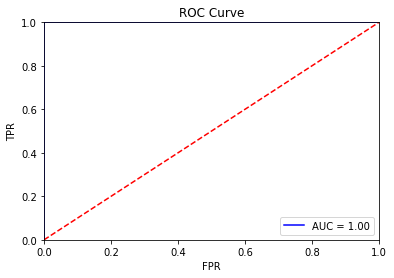

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: Perceptron for classification

ROC_AUC score: 0.8846153846153846


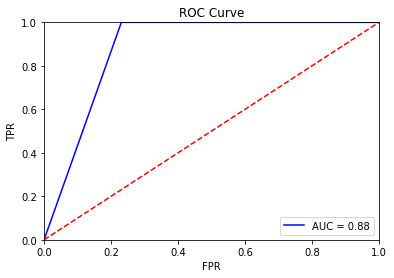

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: KNN Classifier

ROC_AUC score: 1.0


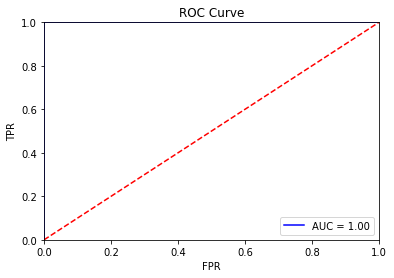

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: Naive Bayes

ROC_AUC score: 0.5


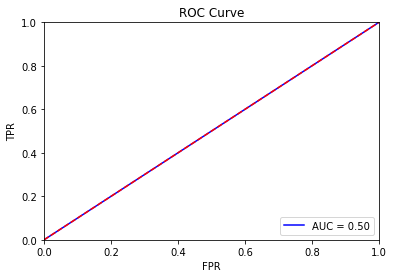

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: Decision Trees

ROC_AUC score: 0.9230769230769231


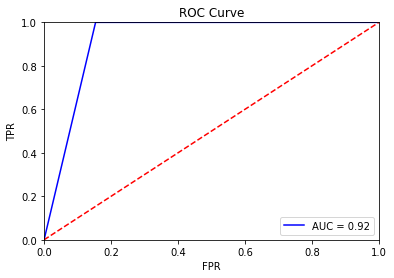

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: SVM

ROC_AUC score: 1.0


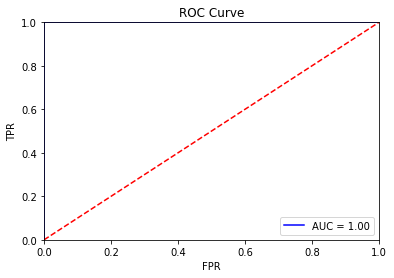

-----------------------------------------------------------------------------------------------


In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
for i in range(len(predictions)):
  pred = predictions[i][0]
  test = predictions[i][1]
  fpr, tpr, thresholds = roc_curve(test, pred)
  roc_auc = roc_auc_score(test, pred)
  print("-----------------------------------------------------------------------------------------------")
  print(f"\nModel: {models[i]}\n")
  print(f"ROC_AUC score: {roc_auc}")  
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.title("ROC Curve")
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('TPR')
  plt.xlabel('FPR')
  plt.show();
  print("-----------------------------------------------------------------------------------------------")
  

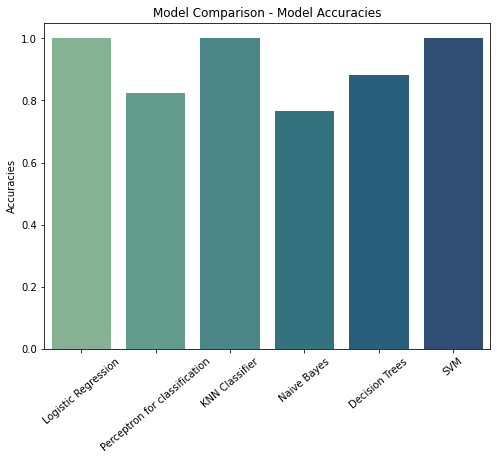

In [ ]:
# Performance of models based on Accuracies 
performance = {}
for i in range(len(models)):
  performance[models[i]] = accuracies[i]
keys = performance.keys()
values = performance.values()


fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=list(keys), y=list(values), palette="crest");
plt.ylabel("Accuracies")
plt.xticks(rotation=40)
plt.title("Model Comparison - Model Accuracies");

Best performing models:
1. Logistic Regression, KNN, SVM
2. Decision Trees
3. Perceptron for classification
4. Naive bayes